# Fig 12

In [2]:
from random_embd.data_import import *
from random_embd.memory_exp import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from plotting import *

In [3]:
device = 'cuda:0'
figure_dir = FIGURE_DIR 

In [4]:
df_orig_learned = load_result_table('feeds/phase_diagram_T32').reset_index()
df_orig_learned = df_orig_learned[df_orig_learned['epoch']==499]


df_orig_random = load_result_table('feeds/random_phase_diagram_T32').reset_index()
df_orig_random = df_orig_random[df_orig_random['epoch']==499]


In [5]:
allowed_p = [2,4,8,16,32,64,128,3, 6, 11, 23, 45, 91]
allowed_model_dim = [2,4,8,16,32,64,128,3, 6, 11, 23, 45, 91]

df_orig_learned = df_orig_learned[df_orig_learned['p'].isin(allowed_p) & df_orig_learned['model_dim'].isin(allowed_model_dim)]
df_orig_random = df_orig_random[df_orig_random['p'].isin(allowed_p) & df_orig_random['model_dim'].isin(allowed_model_dim)]


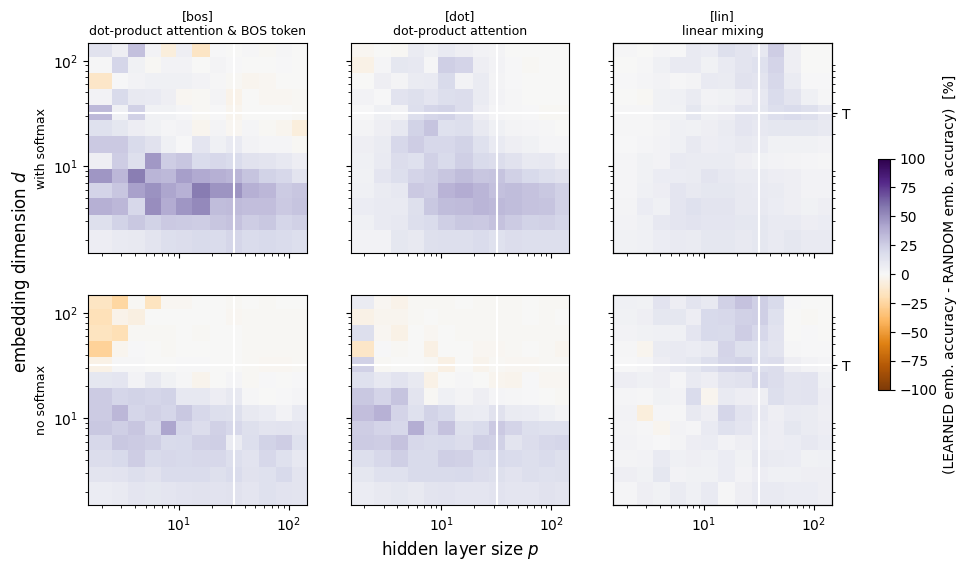

In [6]:
df = (df_orig_learned.groupby(CONFIG_COLS).mean(numeric_only=True) - df_orig_random.groupby(CONFIG_COLS).mean(numeric_only=True) ).reset_index()
df_std = ( df_orig_learned.groupby(CONFIG_COLS).std(numeric_only=True) - df_orig_random.groupby(CONFIG_COLS).std(numeric_only=True)).reset_index()


T = 32
L = 10
k = df[(df['T'] == T) & (df.seq_len == L) ]
k_std = df_std[(df_std['T'] == T) & (df_std.seq_len == L) ]

fig, axes = plt.subplots(2,3,figsize=(12,6),sharex=True,sharey=True)

axes_assignment = {
        'linear': (1,2),
        'linear+sftm': (0,2),
        'dot': (1,1),
        'dot+sftm': (0,1),
        'dotBOS' : (1,0),
        'dotBOS+sftm': (0,0),
}

axes[axes_assignment['linear+sftm']].set_title('[lin]\nlinear mixing',fontsize=9)
axes[axes_assignment['dot+sftm']].set_title('[dot]\ndot-product attention',fontsize=9)
axes[axes_assignment['dotBOS+sftm']].set_title('[bos]\ndot-product attention & BOS token',fontsize=9)

axes[1,0].set_ylabel('no softmax',fontsize=9)
axes[0,0].set_ylabel('with softmax',fontsize=9)
axes[1,1].set_xlabel('hidden layer size $p$',fontsize=12)


for name, model_config in MODELS.items():
    ax = axes[axes_assignment[name]]
    a = k[(k.attention_input == model_config['attention_input'])
            & (k.no_softmax == model_config['no_softmax']) 
            & (k.dataset_type == model_config['dataset'])]
    a_std = k_std[(k_std.attention_input == model_config['attention_input'])
            & (k_std.no_softmax == model_config['no_softmax']) 
            & (k_std.dataset_type == model_config['dataset'])]
    if len(a) == 0:
        continue

    aother = pd.pivot_table(a, index='p', columns='model_dim', values='val_acc')
    smap = ax.pcolor(aother.index, aother.columns, aother.values.T, cmap='PuOr', vmin=-100, vmax=100)
    #smap = ax.scatter(a.p,a.model_dim,  c=a.val_acc,label=name, marker='o', lw=1,vmin=0,vmax=100,cmap='Spectral',s=200)
    
    ax.axvline(T,c='white')
    ax.axhline(T,c='white')
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    if 'linear' in name:
        ax2 = ax.twinx()
        ax2.set_yscale('log')
        ax2.set_ylim(ax.get_ylim())
        ax2.set_yticks([T])
        ax2.set_yticklabels(['T'])
fig.text(0.06, 0.5, 'embedding dimension $d$', va='center', rotation='vertical',fontsize=12)
#smap = plt.cm.ScalarMappable(cmap='Spectral', vmin=0, vmax=100)
fig.colorbar(smap,ax=axes,location='right',shrink=0.5,label='(LEARNED emb. accuracy - RANDOM emb. accuracy)  [%]')
plt.savefig(figure_dir / 'memorizing_counts-phase-diagram-T32-compare.png',bbox_inches='tight')
plt.show()